In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import psycopg2.extras as extras

# Reading the Dataset

In [2]:
df = pd.read_csv("~/Downloads/all_races.csv",sep=",", low_memory=False)

# Preprossesing and Cleaning the data

In [3]:
#identify on the line 146929 an header duplicate in the middle of the dataset
df = df.drop(axis=0, labels=146929)
df.describe()

,place,age_class,place_in_class,bib,name,sex,nation,team,official_time,net_time,birth_date,event,event_year,distance
count,293858,293848,293858,293858,293858,293858,293858,220530,293858,291706,293858,293858,293858,293858
unique,10880,41,2730,14207,39969,2,106,11222,15050,14868,15192,7,7,5
top,992,M20,1,504,Pedro Silva,M,PT,Individual,0 days 00:58:24.000000000,0 days 00:53:04.000000000,01/01/1992,sao-silvestre,2015,10
freq,76,70254,816,60,580,236284,272970,51210,128,152,646,89838,66658,149534


In [4]:
#counting duplicated
print('# of duplicates:',len(df)-len(df.drop_duplicates()))
print('size of df:',len(df))

# of duplicates: 146935
size of df: 293858


In [5]:
#removing the duplicates
df = df.drop_duplicates()
#writing file without duplicates
df.to_csv('~/Downloads/all_races_no_duplicates.csv', index=False)
#Checking the types of the colunms
df.dtypes

place             object
age_class         object
place_in_class    object
bib               object
name              object
sex               object
nation            object
team              object
official_time     object
net_time          object
birth_date        object
event             object
event_year        object
distance          object
dtype: object

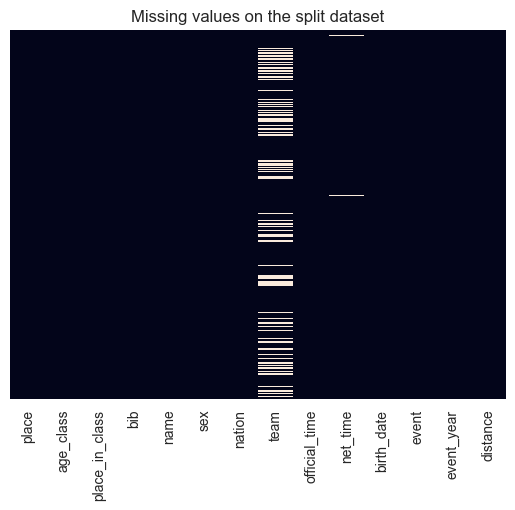

In [6]:
#checking the nulls in the df
sns.heatmap(df.isnull(),cbar=False,cmap='rocket',yticklabels=False)
plt.title('Missing values on the split dataset');

In [7]:
#treating the nulls in the net time. When net time is null, net_time = official_time
df.loc[df['net_time'].isnull(), 'net_time'] = df[df['net_time'].isnull()]['official_time']

In [8]:
#treating the nulls in the team. When net team is null, team= Individual
df.loc[df['team'].isnull(), 'team'] = 'Individual'

In [9]:
#Converting columns type
df['birth_date'] = pd.to_datetime(df['birth_date'])
df['net_time'] = pd.to_timedelta(df['net_time'])
df['official_time'] = pd.to_timedelta(df['official_time'])
df['event_year'] = pd.to_numeric(df['event_year'])

/var/folders/zk/75k1z4rs6_g2dwpqhz8rs1500000gn/T/ipykernel_11462/806395404.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['birth_date'] = pd.to_datetime(df['birth_date'])


## Searching for irregularities

In this section we will search for irregularities in the dataset such as:
- Men that runned in a female run;
- Women that runned in a masculine run;
- People that were in an age class that was not in the correct age
- Names that are not registered corrected.

To perform that we searched that for instance, if a age class is M50, that means tha are running only men in the 50ths.

In [10]:
#creating new columns to perform the check
df['class_gender']=df['age_class'].astype(str).str[0]
df['class_age']=df['age_class'].str[-2:]
df['age']= df['event_year'] - pd.DatetimeIndex(df['birth_date']).year

In [11]:
df.loc[df['age_class'].isnull(), 'age_class'] = df['sex']+df[df['net_time'].isnull()]['official_time']

/var/folders/zk/75k1z4rs6_g2dwpqhz8rs1500000gn/T/ipykernel_11462/3250346233.py:1: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  df.loc[df['age_class'].isnull(), 'age_class'] = df['sex']+df[df['net_time'].isnull()]['official_time']


TypeError: unsupported operand type(s) for +: 'NaTType' and 'str'

In [ ]:
df.loc[(df['age'].loc[13524] > df['class_age'])]

In [12]:
#treating the nulls in the net time. When net time is null, net_time = official_time
#df.loc[df['age_class'].isnull(), 'age_class'] = df['sex']+df['age'].astype(str)
#df.loc[[13524,43207,76596,110156,115456]]

In [13]:
#removing man that run in a fem. class
df = df.drop(index=df[(df['sex']=='M') & (df['class_gender']=='F')].index)
#removing women that runned in a masc. class
df = df.drop(index=df[(df['sex']=='F') & (df['class_gender']=='M')].index)
#removing people ith no legal age to run more than 10km (less than 14 yo), this will also remove inconsistance like (born in the year of the event)
df = df.drop(index=df[df['age']<14].index)
#removing people without age_class
df[df['age_class'].isnull()]

,place,age_class,place_in_class,bib,name,sex,nation,team,official_time,net_time,birth_date,event,event_year,distance,class_gender,class_age,age
13524,1317,NaN,285,1117,João Campos,M,PT,Individual,0 days 00:50:00,0 days 00:49:50,1975-12-20,dia-do-pai,2015,10,n,NaN,40
43207,993,NaN,203,1889,Nuno Ribeiro,M,PT,Individual,0 days 03:54:14,0 days 03:53:49,1979-09-15,maratona,2012,42,n,NaN,33
76569,1127,NaN,253,4149,Nuno Ribeiro,M,PT,Individual,0 days 01:42:15,0 days 01:40:08,1979-09-15,meia_maratona,2015,21,n,NaN,36
110156,4400,NaN,441,9019,Jose Manuel Ribeiro Lages,M,PT,Individual,0 days 01:06:49,0 days 01:04:52,1967-02-02,sao-silvestre,2012,10,n,NaN,45
115456,4808,NaN,1464,7872,André Ferraz,M,PT,Bifanas Team,0 days 00:59:32,0 days 00:53:19,1985-01-31,sao-silvestre,2013,10,n,NaN,28


# Spliting our dataset

For each database we have, we will split in different dataset. This will help to select the data correctly, and allow the code to me more organized. We previously created the databases that did not have any foreing key, than, we merged then to the main df to split their foreing keys to the other tables.
We need to assure that our merges does not duplicate the main table, creating more records than previous stated. So, we decided to perform a lef join with the left table being always (in this case) the main df.

In [14]:
# Team: team name, team id.
df_team = pd.DataFrame([])
df_team['team'] = df['team'].unique()
df_team.insert(0, 'id_team', range(0, 0 + len(df_team)))

In [15]:
# Athlete: id, name, sex, nation, birth_date
df_athlete = df[['name', 'sex','nation','birth_date']].drop_duplicates()
df_athlete.insert(0, 'id_athlete', range(0, 0 + len(df_athlete)))

In [16]:
# Events: event_id, event, event_year, distance
df_events = df[['event', 'event_year', 'distance']].drop_duplicates()
df_events.insert(0, 'id_event', range(0, 0 + len(df_events)))

In [17]:
# populate id_athlete on df
df = pd.merge(df,df_athlete[['name','birth_date','sex','nation','id_athlete']], how='left', on=['name','birth_date','sex','nation'])

In [18]:
#populate id_team on df
df = pd.merge(df,df_team[['team','id_team']], how='left', on=['team'])

In [19]:
#populate id_event on df
df = pd.merge(df,df_events[['event','event_year', 'distance','id_event']], how='left', on=['event', 'event_year', 'distance'])

In [20]:
# Runner: id_runner, bib, age_class, id_event, id_athlete
df_runner = df[['bib','age_class','id_athlete','id_event']].drop_duplicates()
df_runner.insert(0, 'id_runner', range(0, 0 + len(df_runner)))

In [21]:
# populate runner_id
df = pd.merge(df,df_runner[['bib','age_class','id_athlete','id_event','id_runner']], how='left', on=['bib','age_class','id_athlete','id_event'])

In [39]:
df_runner_team = df[['id_team','id_runner']].drop_duplicates()
df_runner_team['id_team'] = df_runner_team['id_team'].astype(str)
df_runner_team['id_runner'] = df_runner_team['id_runner'].astype(str)
df_runner_team.dtypes

id_team      object
id_runner    object
dtype: object

In [49]:
# Event_ranking: id_event, id_runner, place, place_in_class, official_time, net_time
df_ranking = df[['place','place_in_class', 'official_time', 'net_time','id_runner','id_event']].drop_duplicates()

# Inserting in the Postgrees

In [45]:
#connecting with Postgrees
con = psycopg2.connect(
  database="fced_diogo_cruz",             # your database is the same as your username
  user="fced_diogo_cruz",                 # your username
  password="fced_diogo_cruz",             # your password
  host="dbm.fe.up.pt",                    # the database host
  options='-c search_path=schema_grupo5',
  port="5433"                            # use the schema you want to connect to
)

In [53]:
 #Creating a cursor object using the cursor() method
cursor = con.cursor()
cursor.execute("TRUNCATE events CASCADE")
print("Table dropped... ")
#Commit your changes in the database
con.commit()
#Closing the connection
con.close()

Table dropped... 


In [31]:
#events
cur = con.cursor()
table="events"
cols = ','.join(list(df_events.columns))
query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
tuples = [tuple(x) for x in df_events.to_numpy()]

try:

    extras.execute_values(cur, query, tuples)
    con.commit()
    print("the dataframe is inserted")
except (Exception, psycopg2.DatabaseError) as error:
    print("Error: %s" % error)
    con.rollback()
    cur.close()
cur.close()

INSERT INTO events(id_event,event,event_year,distance) VALUES %s
the dataframe is inserted


In [32]:
#athlete
cur = con.cursor()
table="athlete"
cols = ','.join(list(df_athlete.columns))
query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
tuples = [tuple(x) for x in df_athlete.to_numpy()]

try:

    extras.execute_values(cur, query, tuples)
    con.commit()
    print("the dataframe is inserted")
except (Exception, psycopg2.DatabaseError) as error:
    print("Error: %s" % error)
    con.rollback()
    cur.close()
cur.close()

the dataframe is inserted


In [33]:
#team
cur = con.cursor()
table="teams"
cols = ','.join(list(df_team.columns))
query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
tuples = [tuple(x) for x in df_team.to_numpy()]

try:

    extras.execute_values(cur, query, tuples)
    con.commit()
    print("the dataframe is inserted")
except (Exception, psycopg2.DatabaseError) as error:
    print("Error: %s" % error)
    con.rollback()
    cur.close()
cur.close()

the dataframe is inserted


In [47]:
#runner
cur = con.cursor()
table="runner"
cols = ','.join(list(df_runner.columns))
query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
tuples = [tuple(x) for x in df_runner.to_numpy()]

try:
    extras.execute_values(cur, query, tuples)
    con.commit()
    print("the dataframe is inserted")
except (Exception, psycopg2.DatabaseError) as error:
    print("Error: %s" % error)
    con.rollback()
    cur.close()
cur.close()

the dataframe is inserted


In [48]:
#runner_team
cur = con.cursor()
table="runner_teams"
cols = ','.join(list(df_runner_team.columns))
query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
tuples = [tuple(x) for x in df_runner_team.to_numpy()]

try:
    extras.execute_values(cur, query, tuples)
    con.commit()
    print("the dataframe is inserted")
except (Exception, psycopg2.DatabaseError) as error:
    print("Error: %s" % error)
    con.rollback()
    cur.close()
cur.close()

the dataframe is inserted


In [50]:
#event_ranking
cur = con.cursor()
table="event_ranking"
cols = ','.join(list(df_ranking.columns))
query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
tuples = [tuple(x) for x in df_ranking.to_numpy()]

try:
    extras.execute_values(cur, query, tuples)
    con.commit()
    print("the dataframe is inserted")
except (Exception, psycopg2.DatabaseError) as error:
    print("Error: %s" % error)
    con.rollback()
    cur.close()
cur.close()

the dataframe is inserted
